**This notebook is used to run map-reduce tasks on the reddit comments dataset. Anaylsis and visulization of the results are also included.**

# Installing Hadoop

In [2]:
!wget https://downloads.apache.org/hadoop/common/hadoop-3.3.4/hadoop-3.3.4.tar.gz

--2022-11-29 12:50:20--  https://downloads.apache.org/hadoop/common/hadoop-3.3.4/hadoop-3.3.4.tar.gz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.95.219, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 695457782 (663M) [application/x-gzip]
Saving to: ‘hadoop-3.3.4.tar.gz’

hadoop-3.3.4.tar.gz 100%[===================>] 663.24M  10.5MB/s    in 64s     

2022-11-29 12:51:25 (10.4 MB/s) - ‘hadoop-3.3.4.tar.gz’ saved [695457782/695457782]



In [3]:
!tar -xzvf hadoop-3.3.4.tar.gz

Streaming output truncated to the last 5000 lines.
hadoop-3.3.4/share/doc/hadoop/hadoop-yarn/hadoop-yarn-server/hadoop-yarn-server-nodemanager/apidocs/org/apache/hadoop/yarn/server/nodemanager/containermanager/resourceplugin/deviceframework/package-tree.html
hadoop-3.3.4/share/doc/hadoop/hadoop-yarn/hadoop-yarn-server/hadoop-yarn-server-nodemanager/apidocs/org/apache/hadoop/yarn/server/nodemanager/containermanager/resourceplugin/deviceframework/DeviceMappingManager.html
hadoop-3.3.4/share/doc/hadoop/hadoop-yarn/hadoop-yarn-server/hadoop-yarn-server-nodemanager/apidocs/org/apache/hadoop/yarn/server/nodemanager/containermanager/resourceplugin/deviceframework/DeviceResourceHandlerImpl.html
hadoop-3.3.4/share/doc/hadoop/hadoop-yarn/hadoop-yarn-server/hadoop-yarn-server-nodemanager/apidocs/org/apache/hadoop/yarn/server/nodemanager/containermanager/resourceplugin/deviceframework/ShellWrapper.html
hadoop-3.3.4/share/doc/hadoop/hadoop-yarn/hadoop-yarn-server/hadoop-yarn-server-nodemanager/apid

In [4]:
#copy  hadoop file to user/local
!cp -r hadoop-3.3.4/ /usr/local/

In [5]:
#To find the default Java path
!readlink -f /usr/bin/java | sed "s:bin/java::"

/usr/lib/jvm/java-11-openjdk-amd64/


In [7]:
#Running Hadoop
!/usr/local/hadoop-3.3.4/bin/hadoop

Usage: hadoop [OPTIONS] SUBCOMMAND [SUBCOMMAND OPTIONS]
 or    hadoop [OPTIONS] CLASSNAME [CLASSNAME OPTIONS]
  where CLASSNAME is a user-provided Java class

  OPTIONS is none or any of:

buildpaths                       attempt to add class files from build tree
--config dir                     Hadoop config directory
--debug                          turn on shell script debug mode
--help                           usage information
hostnames list[,of,host,names]   hosts to use in slave mode
hosts filename                   list of hosts to use in slave mode
loglevel level                   set the log4j level for this command
workers                          turn on worker mode

  SUBCOMMAND is one of:


    Admin Commands:

daemonlog     get/set the log level for each daemon

    Client Commands:

archive       create a Hadoop archive
checknative   check native Hadoop and compression libraries availability
classpath     prints the class path needed to get the Hadoop jar and the
    

In [8]:
!mkdir ~/input
!cp /usr/local/hadoop-3.3.4/etc/hadoop/*.xml ~/input

In [23]:
!ls ~/input

capacity-scheduler.xml	hdfs-rbf-site.xml  kms-acls.xml     yarn-site.xml
core-site.xml		hdfs-site.xml	   kms-site.xml
hadoop-policy.xml	httpfs-site.xml    mapred-site.xml


## Example

In [ ]:
!/usr/local/hadoop-3.3.4/bin/hadoop jar /usr/local/hadoop-3.3.4/share/hadoop/mapreduce/hadoop-mapreduce-examples-3.3.4.jar grep ~/input ~/grep_example 'allowed[.]*'

In [26]:
!cat ~/grep_example/*

22	allowed.
1	allowed


# Reddit Comments Analysis

In [46]:
!find / -name 'hadoop-streaming*.jar'

find: ‘/proc/46/task/46/net’: Invalid argument
find: ‘/proc/46/net’: Invalid argument
/usr/local/hadoop-3.3.4/share/hadoop/tools/sources/hadoop-streaming-3.3.4-test-sources.jar
/usr/local/hadoop-3.3.4/share/hadoop/tools/sources/hadoop-streaming-3.3.4-sources.jar
/usr/local/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar
/content/hadoop-3.3.4/share/hadoop/tools/sources/hadoop-streaming-3.3.4-test-sources.jar
/content/hadoop-3.3.4/share/hadoop/tools/sources/hadoop-streaming-3.3.4-sources.jar
/content/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar


## Loading the dataset

In [27]:
# Dowloading the dataset

# A code snippet to download the dataset file from a Gdrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.

file_id = '1-D_uHkn37M5ptWVQl8a5-q8NBv9jaLWr'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('dataset.bz2')
!mv dataset.bz2 /content

In [251]:
# sampling 1 million entries to test our mapreduce jobs
%cd /content
!bzcat dataset.bz2 | head -1000000 >> sample1m.txt

/content


## Loading map-reduce files from github 

In [252]:
!git clone https://github.com/khaledElbastawisy/reddit-comments-anaylsis.git
%cd /content/reddit-comments-anaylsis
!ls

Cloning into 'reddit-comments-anaylsis'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 51 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), done.


## Top Subreddits

This job output the top N subreddits where N is an argument to the reducer (we chose it to be 20)

In [255]:
%cd /content/reddit-comments-anaylsis/top_subs
!chmod u+rwx mapper.py
!chmod u+rwx reducer.py

/content/reddit-comments-anaylsis/top_subs


In [257]:
!rm -r output*

In [258]:
!/usr/local/hadoop-3.3.4/bin/hadoop jar /usr/local/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar \
-input /content/sample1m.txt -output /content/reddit-comments-anaylsis/top_subs/output -file mapper.py -file reducer.py -mapper 'python mapper.py' -reducer 'python reducer.py 20'

2022-11-29 17:54:36,997 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper.py, reducer.py] [] /tmp/streamjob15452534733751184576.jar tmpDir=null
2022-11-29 17:54:37,916 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2022-11-29 17:54:38,130 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2022-11-29 17:54:38,130 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2022-11-29 17:54:38,157 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2022-11-29 17:54:38,340 INFO mapred.FileInputFormat: Total input files to process : 1
2022-11-29 17:54:38,368 INFO mapreduce.JobSubmitter: number of splits:18
2022-11-29 17:54:38,789 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1488959852_0001
2022-11-29 17:54:38,789 INFO mapreduce.JobSubmitter: Executing with tokens: []
2022-11-29 17:54:39,192 INFO mapred.LocalDistributedCac

In [259]:
!cat output/part*

AskReddit 	81813
CFB 	22836
funny 	18465
pics 	18176
pcmasterrace 	15148
leagueoflegends 	14424
soccer 	14115
todayilearned 	13419
hockey 	11781
worldnews 	10993
videos 	10619
AdviceAnimals 	10302
nba 	9998
DotA2 	9897
GlobalOffensive 	8948
news 	8554
WTF 	8321
DestinyTheGame 	8233
nfl 	8059
gaming 	7777


In [260]:
!cp output/part-00000 /content/reddit-comments-anaylsis/topsubs.txt

## Top Topics per Subreddit

This job outputs the top discussed topics asscoiated with every subreddit. You could choose to run the job on a specific list of subreddits which we chose to be the top 20 subreddits obtained earlier. The file name could be passed as an argument to the first mapper, otherwise if the argument is empty all subreddits are analyzed.

In [264]:
%cd /content/reddit-comments-anaylsis/top_topics_sub
!ls

/content/reddit-comments-anaylsis/top_topics_sub
mapper2.py  output1  reducer2.py  sample10k.txt  topsubs.txt
mapper.py   output2  reducer.py   test.txt


In [265]:
# top subbreddits list 
!cp /content/reddit-comments-anaylsis/topsubs.txt /content/reddit-comments-anaylsis/top_topics_sub

In [266]:
!chmod u+rwx mapper.py
!chmod u+rwx reducer.py
!chmod u+rwx mapper2.py
!chmod u+rwx reducer2.py

In [267]:
!rm -r output*

In [268]:
# first map-reduce job
!/usr/local/hadoop-3.3.4/bin/hadoop jar /usr/local/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar \
-input /content/sample1m.txt -output /content/reddit-comments-anaylsis/top_topics_sub/output1 -file mapper.py -file reducer.py -mapper 'python mapper.py topsubs.txt' -reducer 'python reducer.py'

2022-11-29 18:04:21,700 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper.py, reducer.py] [] /tmp/streamjob12045861220950396287.jar tmpDir=null
2022-11-29 18:04:22,535 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2022-11-29 18:04:22,782 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2022-11-29 18:04:22,782 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2022-11-29 18:04:22,815 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2022-11-29 18:04:23,024 INFO mapred.FileInputFormat: Total input files to process : 1
2022-11-29 18:04:23,065 INFO mapreduce.JobSubmitter: number of splits:18
2022-11-29 18:04:23,501 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1523607083_0001
2022-11-29 18:04:23,501 INFO mapreduce.JobSubmitter: Executing with tokens: []
2022-11-29 18:04:23,957 INFO mapred.LocalDistributedCac

In [269]:
!cat output1/part*

Streaming output truncated to the last 5000 lines.
GlobalOffensive 	 anticipationreaction	1
GlobalOffensive 	 uk	1
GlobalOffensive 	 tits	1
GlobalOffensive 	 pinks	1
GlobalOffensive 	 ittylays	1
GlobalOffensive 	 viewer	1
GlobalOffensive 	 omp	1
GlobalOffensive 	 byali	4
GlobalOffensive 	 releases	1
GlobalOffensive 	 steamcommunitycomidetuk	1
GlobalOffensive 	 arambits	1
GlobalOffensive 	 backside	1
GlobalOffensive 	 implies	1
GlobalOffensive 	 rvacporn	2
GlobalOffensive 	 entertainer	1
GlobalOffensive 	 teh	1
GlobalOffensive 	 skadoodle	4
GlobalOffensive 	 scientists	1
GlobalOffensive 	 ravo	2
GlobalOffensive 	 peasants	1
GlobalOffensive 	 ilber	1
GlobalOffensive 	 researches	1
GlobalOffensive 	 kioshima	3
GlobalOffensive 	 nreal	1
GlobalOffensive 	 hapes	1
GlobalOffensive 	 sci	1
GlobalOffensive 	 fi	1
GlobalOffensive 	 appeal	1
GlobalOffensive 	 whirpool	1
GlobalOffensive 	 hobo	2
GlobalOffensive 	 ncle	3
GlobalOffensive 	 ommy	3
GlobalOffensive 	 ruckus	1
GlobalOffensive 	 daughter

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [270]:
# second map-reduce job
!/usr/local/hadoop-3.3.4/bin/hadoop jar /usr/local/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar \
-input /content/reddit-comments-anaylsis/top_topics_sub/output1/part-00000 -output /content/reddit-comments-anaylsis/top_topics_sub/output2 -file mapper2.py -file reducer2.py\
-mapper 'python mapper2.py' -reducer 'python reducer2.py'

2022-11-29 18:14:10,966 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper2.py, reducer2.py] [] /tmp/streamjob7672001057511394142.jar tmpDir=null
2022-11-29 18:14:11,793 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2022-11-29 18:14:12,020 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2022-11-29 18:14:12,020 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2022-11-29 18:14:12,045 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2022-11-29 18:14:12,231 INFO mapred.FileInputFormat: Total input files to process : 1
2022-11-29 18:14:12,256 INFO mapreduce.JobSubmitter: number of splits:1
2022-11-29 18:14:12,612 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local429153850_0001
2022-11-29 18:14:12,612 INFO mapreduce.JobSubmitter: Executing with tokens: []
2022-11-29 18:14:13,099 INFO mapred.LocalDistributedCach

In [271]:
!cat output2/part*

AdviceAnimals 	 gt	977
AskReddit 	 amp	14798
CFB 	 game	1916
DestinyTheGame 	 people	817
DotA2 	 game	1025
GlobalOffensive 	 http	919
WTF 	 people	586
funny 	 people	840
gaming 	 game	1138
hockey 	 game	826
leagueoflegends 	 game	1130
nba 	 game	784
news 	 people	1524
nfl 	 year	760
pcmasterrace 	 games	1615
pics 	 people	817
soccer 	 team	826
todayilearned 	 people	1286
videos 	 time	787


## Top Upvoted and Top Downvoted Topics

This job outputs the most upvoted and downvoted N topics where N is an argument to the reducer (we chose it to be 20). Mapper should take an argument 0 or 1 for upvotes and downvotes respectively

In [272]:
%cd /content/reddit-comments-anaylsis/top_topics_votes
!ls

/content/reddit-comments-anaylsis/top_topics_votes
mapper.py  outputdown  outputup  reducer.py  sample10k.txt


In [273]:
!chmod u+rwx mapper.py
!chmod u+rwx reducer.py

In [274]:
!rm -r output*

### Top Upvoted

In [ ]:
!/usr/local/hadoop-3.3.4/bin/hadoop jar /usr/local/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar \
-input /content/sample1m.txt -output /content/reddit-comments-anaylsis/top_topics_votes/outputup  -file mapper.py -file reducer.py\
-mapper 'python mapper.py 0' -reducer 'python reducer.py 20'

2022-11-29 18:16:06,407 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper.py, reducer.py] [] /tmp/streamjob18165548417953744007.jar tmpDir=null
2022-11-29 18:16:07,273 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2022-11-29 18:16:07,506 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2022-11-29 18:16:07,506 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2022-11-29 18:16:07,531 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2022-11-29 18:16:07,693 INFO mapred.FileInputFormat: Total input files to process : 1
2022-11-29 18:16:07,715 INFO mapreduce.JobSubmitter: number of splits:18
2022-11-29 18:16:08,036 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1518016611_0001
2022-11-29 18:16:08,036 INFO mapreduce.JobSubmitter: Executing with tokens: []
2022-11-29 18:16:08,465 INFO mapred.LocalDistributedCac

In [279]:
!cat outputup/part*

people 	511262
http 	387847
time 	383848
gt 	275805
year 	270307
way 	224865
something 	202841
game 	190381
years 	184724
day 	167882
lot 	165865
thing 	158378
guy 	156120
someone 	147795
life 	137882
things 	134859
man 	127943
amp 	125091
dit 	124401
https 	122619


### Top Downvotes
Note: All of the sampled comments have zero downvotes

In [ ]:
!/usr/local/hadoop-3.3.4/bin/hadoop jar /usr/local/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar \
-input /content/sample1m.txt -output /content/reddit-comments-anaylsis/top_topics_votes/outputdown -file mapper.py -file reducer.py\
-mapper 'python mapper.py 1' -reducer 'python reducer.py 20'

In [ ]:
!cat outputdown/part*

## Top Users per Subreddit

This works the same way as top topics per subreddit except that it anaylzes top users asscoiated with subreddits. Only top subreddits could also be used.

In [280]:
%cd /content/reddit-comments-anaylsis/top_user_per_sub
!ls

/content/reddit-comments-anaylsis/top_user_per_sub
mapper2.py  mapper.py  output1	output2  reducer2.py  reducer.py  topsubs.txt


In [282]:
# copying the top subreddits list
!cp /content/reddit-comments-anaylsis/topsubs.txt /content/reddit-comments-anaylsis/top_user_per_sub

In [283]:
!chmod u+rwx mapper.py
!chmod u+rwx reducer.py
!chmod u+rwx mapper2.py
!chmod u+rwx reducer2.py

In [284]:
!rm -r output*

In [286]:
# first map-reduce job
!/usr/local/hadoop-3.3.4/bin/hadoop jar /usr/local/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar \
-input /content/sample1m.txt -output /content/reddit-comments-anaylsis/top_user_per_sub/output1 -file mapper.py -file reducer.py -mapper 'python mapper.py topsubs.txt' -reducer 'python reducer.py'

2022-11-29 18:54:08,564 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper.py, reducer.py] [] /tmp/streamjob3233764934274991020.jar tmpDir=null
2022-11-29 18:54:09,274 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2022-11-29 18:54:09,520 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2022-11-29 18:54:09,520 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2022-11-29 18:54:09,550 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2022-11-29 18:54:09,767 INFO mapred.FileInputFormat: Total input files to process : 1
2022-11-29 18:54:09,794 INFO mapreduce.JobSubmitter: number of splits:18
2022-11-29 18:54:10,142 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1332381848_0001
2022-11-29 18:54:10,142 INFO mapreduce.JobSubmitter: Executing with tokens: []
2022-11-29 18:54:10,590 INFO mapred.LocalDistributedCach

In [287]:
!cat output1/part*

Streaming output truncated to the last 5000 lines.
leagueoflegends 	 Draadsnijijzer	1
leagueoflegends 	 ANewLeeSinLife	2
leagueoflegends 	 ninbushido	2
leagueoflegends 	 Hamstra	2
leagueoflegends 	 NOA_	1
leagueoflegends 	 Malferon	2
leagueoflegends 	 gomsybose	1
leagueoflegends 	 Ghostlymagi	1
leagueoflegends 	 GrandpaDave	1
leagueoflegends 	 NerdhausNA	1
leagueoflegends 	 Prad3nas	2
leagueoflegends 	 Yasuo600	1
leagueoflegends 	 fizzord	1
leagueoflegends 	 Aurori	1
leagueoflegends 	 TheDWGM	4
leagueoflegends 	 ViktorViktorov	5
leagueoflegends 	 UncoChen	2
leagueoflegends 	 gkardos	1
leagueoflegends 	 Simmseh	1
leagueoflegends 	 kakastrophe	2
leagueoflegends 	 Hackcident	1
leagueoflegends 	 bebewow	1
leagueoflegends 	 SnowmanWithAScarf	1
leagueoflegends 	 bwlizback	1
leagueoflegends 	 Lamberti	1
leagueoflegends 	 BfMDevOuR	1
leagueoflegends 	 Bloozeclooz	1
leagueoflegends 	 5minShortStory	1
leagueoflegends 	 Jebne	1
leagueoflegends 	 WurfyMK	1
leagueoflegends 	 jSnax	1
leagueoflegends

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [288]:
# second map-reduce job
!/usr/local/hadoop-3.3.4/bin/hadoop jar /usr/local/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar \
-input /content/reddit-comments-anaylsis/top_user_per_sub/output1/part-00000 \
-output /content/reddit-comments-anaylsis/top_user_per_sub/output2 -file mapper2.py -file reducer2.py\
-mapper 'python mapper2.py' -reducer 'python reducer2.py'

2022-11-29 18:54:52,447 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper2.py, reducer2.py] [] /tmp/streamjob1832536255843851503.jar tmpDir=null
2022-11-29 18:54:53,276 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2022-11-29 18:54:53,535 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2022-11-29 18:54:53,535 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2022-11-29 18:54:53,566 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2022-11-29 18:54:53,787 INFO mapred.FileInputFormat: Total input files to process : 1
2022-11-29 18:54:53,813 INFO mapreduce.JobSubmitter: number of splits:1
2022-11-29 18:54:54,148 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local150723973_0001
2022-11-29 18:54:54,148 INFO mapreduce.JobSubmitter: Executing with tokens: []
2022-11-29 18:54:54,575 INFO mapred.LocalDistributedCach

In [289]:
!cat output2/part*

AdviceAnimals 	 imgurtranscriber	189
AskReddit 	 Late_Night_Grumbler	275
CFB 	 OnthefarWind	232
DestinyTheGame 	 WID_Call_IT	53
DotA2 	 DoctorCatface	92
GlobalOffensive 	 gravyenema	75
WTF 	 3Effie412	67
funny 	 LOHare	63
gaming 	 LizardKahn	29
hockey 	 Probablywontreadthis	193
leagueoflegends 	 iambalt	56
nba 	 JudgeJBS	245
news 	 stillclub	35
nfl 	 readonlypdf	46
pcmasterrace 	 _THAT_GUY__	64
pics 	 FaceBadger	148
soccer 	 Kluey	73
todayilearned 	 the_rabble_alliance	50
videos 	 shakeyjake	41


## Top Users

This job output the most engaging N users excluding bots and deleted authors. N is an input to the reducer (we chose it to be 20)

In [290]:
%cd /content/reddit-comments-anaylsis/top_users
!ls

/content/reddit-comments-anaylsis/top_users
mapper.py  output  reducer.py


In [291]:
!chmod u+rwx mapper.py
!chmod u+rwx reducer.py

In [292]:
!rm -r output

In [293]:
!/usr/local/hadoop-3.3.4/bin/hadoop jar /usr/local/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar \
-input /content/sample1m.txt -output /content/reddit-comments-anaylsis/top_users/output -file mapper.py -file reducer.py -mapper 'python mapper.py' -reducer 'python reducer.py 20'

2022-11-29 18:55:28,814 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper.py, reducer.py] [] /tmp/streamjob3898435963929682773.jar tmpDir=null
2022-11-29 18:55:29,694 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2022-11-29 18:55:29,903 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2022-11-29 18:55:29,904 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2022-11-29 18:55:29,933 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2022-11-29 18:55:30,095 INFO mapred.FileInputFormat: Total input files to process : 1
2022-11-29 18:55:30,144 INFO mapreduce.JobSubmitter: number of splits:18
2022-11-29 18:55:30,488 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local435995117_0001
2022-11-29 18:55:30,489 INFO mapreduce.JobSubmitter: Executing with tokens: []
2022-11-29 18:55:30,889 INFO mapred.LocalDistributedCache

In [294]:
!cat output/part*

MayTentacleBeWithYee 	590
XoXFaby 	475
Jake0110 	438
jonandkaylatoler 	422
Sabrina_Cage 	337
Peacehippo 	297
king_kalamari 	281
Late_Night_Grumbler 	278
blaudrache0084 	275
Shadow-Pie 	273
Thief39 	254
FonsoTheWhitesican 	253
JudgeJBS 	251
subredditreports 	248
timewaitsforsome 	247
Phelan_Hobbs 	244
OnthefarWind 	240
Mrs_Holman_7 	234
TweetPoster 	228
Aidan_Fikri 	227


In [295]:
!cp output/part-00000 /content/reddit-comments-anaylsis/topusers.txt

## Top Topics per User

In [296]:
%cd /content/reddit-comments-anaylsis/top_topics_user
!ls

/content/reddit-comments-anaylsis/top_topics_user
mapper2.py  mapper.py  output1	output2  reducer2.py  reducer.py  topusers.txt


In [298]:
# copying the list of top users into the dir
!cp /content/reddit-comments-anaylsis/topusers.txt /content/reddit-comments-anaylsis/top_topics_user

In [299]:
!chmod u+rwx mapper.py
!chmod u+rwx reducer.py
!chmod u+rwx mapper2.py
!chmod u+rwx reducer2.py

In [300]:
!rm -r output*

In [301]:
# first map-reduce job
!/usr/local/hadoop-3.3.4/bin/hadoop jar /usr/local/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar \
-input /content/sample1m.txt -output /content/reddit-comments-anaylsis/top_topics_user/output1 -file mapper.py -file reducer.py -mapper 'python mapper.py topusers.txt' -reducer 'python reducer.py'

2022-11-29 18:56:40,488 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper.py, reducer.py] [] /tmp/streamjob4121365639596039298.jar tmpDir=null
2022-11-29 18:56:41,254 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2022-11-29 18:56:41,460 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2022-11-29 18:56:41,460 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2022-11-29 18:56:41,495 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2022-11-29 18:56:41,698 INFO mapred.FileInputFormat: Total input files to process : 1
2022-11-29 18:56:41,729 INFO mapreduce.JobSubmitter: number of splits:18
2022-11-29 18:56:42,076 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local586283836_0001
2022-11-29 18:56:42,076 INFO mapreduce.JobSubmitter: Executing with tokens: []
2022-11-29 18:56:42,527 INFO mapred.LocalDistributedCache

In [302]:
!cat output1/part*

Streaming output truncated to the last 5000 lines.
subredditreports 	 uj	1
subredditreports 	 uwatyousay	1
subredditreports 	 umcnugglet	1
subredditreports 	 ugarythecoconut	1
subredditreports 	 ucmadr	1
subredditreports 	 uizec	1
subredditreports 	 uedmau	1
subredditreports 	 ulimericksantorum	1
subredditreports 	 uylatystem	2
subredditreports 	 ucatdogsboner	1
subredditreports 	 uejoo	1
subredditreports 	 ugmz	1
subredditreports 	 ueoanthera	1
subredditreports 	 uintnotadorkus	1
subredditreports 	 uquiltedvino	1
subredditreports 	 uscoops	1
subredditreports 	 ucellshadedninjastar	1
subredditreports 	 uaijinragon	1
subredditreports 	 uvensamape	1
subredditreports 	 uerebro	1
subredditreports 	 utankyung	2
subredditreports 	 uyouareaturkey	1
subredditreports 	 uidjtd	1
subredditreports 	 uougyanger	1
subredditreports 	 uvsonary	1
subredditreports 	 uthegingr	1
subredditreports 	 usamainadenoes	1
subredditreports 	 usnoopdin	1
subredditreports 	 uswordfishtromboners	1
subredditreports 	

In [303]:
# second map-reduce job
!/usr/local/hadoop-3.3.4/bin/hadoop jar /usr/local/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar \
-input /content/reddit-comments-anaylsis/top_topics_user/output1/part-00000 \
-output /content/reddit-comments-anaylsis/top_topics_user/output2 -file mapper2.py -file reducer2.py\
-mapper 'python mapper2.py' -reducer 'python reducer2.py'

2022-11-29 18:57:52,320 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper2.py, reducer2.py] [] /tmp/streamjob10366549113397630923.jar tmpDir=null
2022-11-29 18:57:53,464 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2022-11-29 18:57:53,651 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2022-11-29 18:57:53,651 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2022-11-29 18:57:53,684 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2022-11-29 18:57:53,889 INFO mapred.FileInputFormat: Total input files to process : 1
2022-11-29 18:57:53,922 INFO mapreduce.JobSubmitter: number of splits:1
2022-11-29 18:57:54,479 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local906518421_0001
2022-11-29 18:57:54,480 INFO mapreduce.JobSubmitter: Executing with tokens: []
2022-11-29 18:57:55,048 INFO mapred.LocalDistributedCac

In [304]:
!cat output2/part*

Aidan_Fikri 	 smile	25
FonsoTheWhitesican 	 bobross	75
Jake0110 	 agnus	59
JudgeJBS 	 game	27
Late_Night_Grumbler 	 people	11
MayTentacleBeWithYee 	 omoe	79
Mrs_Holman_7 	 people	11
OnthefarWind 	 game	30
Peacehippo 	 ew	25
Phelan_Hobbs 	 cadgym	244
Sabrina_Cage 	 stars	16
Shadow-Pie 	 den	29
Thief39 	 ods	19
TweetPoster 	 https	1294
XoXFaby 	 east	14
blaudrache0084 	 ermany	24
jonandkaylatoler 	 lol	28
king_kalamari 	 haun	24
subredditreports 	 http	3686


## Attitude of user based on their comments (sentiment analysis)


This job analyzes the comments of users and outputs a ratio of positivity to negativity of their overall activity on all subreddits. A ratio greater than one means an overall positive attitude and the larger the number the merrier. A ratio between zero and one implies a negative attitude being more negative as it gets closer to zero.

P.S We could choose to analyze top users only like we did in previous jobs

In [421]:
# installed the required library for sentiment anaylsis
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.1 MB/s 


In [417]:
%cd /content/reddit-comments-anaylsis/users_attitude
!ls

/content/reddit-comments-anaylsis/users_attitude
mapper.py  reducer.py


In [418]:
# copying the list of top users into the dir
!cp /content/reddit-comments-anaylsis/topusers.txt /content/reddit-comments-anaylsis/users_attitude

In [419]:
!chmod u+rwx mapper.py
!chmod u+rwx reducer.py

In [423]:
!rm -r output*

In [424]:
# first map-reduce job
!/usr/local/hadoop-3.3.4/bin/hadoop jar /usr/local/hadoop-3.3.4/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar \
-input /content/sample1m.txt -output /content/reddit-comments-anaylsis/users_attitude/output -file mapper.py -file reducer.py -mapper 'python mapper.py topusers.txt' -reducer 'python reducer.py'

2022-11-29 21:44:01,225 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper.py, reducer.py] [] /tmp/streamjob8111620914208573058.jar tmpDir=null
2022-11-29 21:44:01,963 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2022-11-29 21:44:02,206 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2022-11-29 21:44:02,206 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2022-11-29 21:44:02,234 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2022-11-29 21:44:02,402 INFO mapred.FileInputFormat: Total input files to process : 1
2022-11-29 21:44:02,426 INFO mapreduce.JobSubmitter: number of splits:18
2022-11-29 21:44:02,805 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1054942231_0001
2022-11-29 21:44:02,805 INFO mapreduce.JobSubmitter: Executing with tokens: []
2022-11-29 21:44:03,249 INFO mapred.LocalDistributedCach

In [425]:
!cat output/part*

Aidan_Fikri 	3.73655773420479
FonsoTheWhitesican 	2.684472049689442
Jake0110 	2.321061873158534
JudgeJBS 	1.214373056632778
Late_Night_Grumbler 	1.018233880788599
MayTentacleBeWithYee 	2.1381464938615107
Mrs_Holman_7 	1.9456087219866747
OnthefarWind 	1.9013616583220228
Peacehippo 	7.579104857706753
Phelan_Hobbs 	4.105305726302167
Sabrina_Cage 	2.43076789813331
Shadow-Pie 	0.7468479025076168
Thief39 	2.891084487319124
TweetPoster 	0.6594524402120981
XoXFaby 	1.907843396600753
blaudrache0084 	2.7785238751147845
jonandkaylatoler 	3.309633733456448
king_kalamari 	4.062365591397851
subredditreports 	1.235776128633272


# Results analysis and visualizations

In [353]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

## Top Subreddits Distribution

In [349]:
topsubs = pd.read_csv('/content/reddit-comments-anaylsis/topsubs.txt', sep="\t", header=None)
topsubs.columns = ['subreddit', 'instances']

<Figure size 432x288 with 0 Axes>

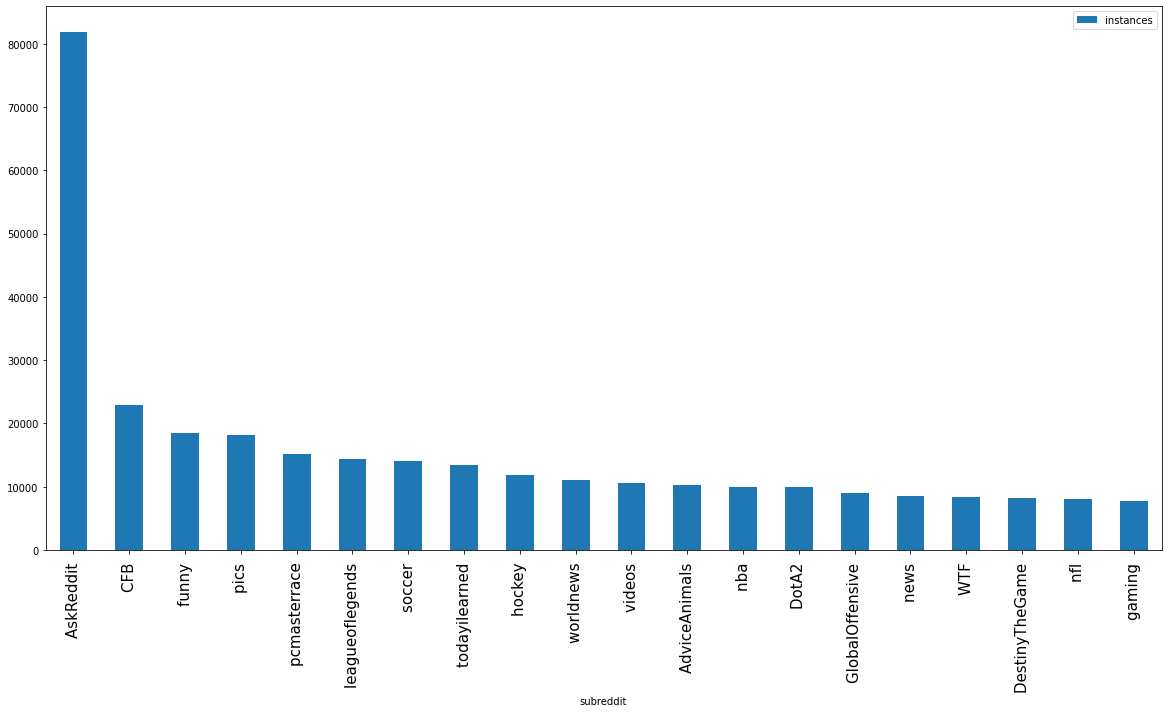

In [350]:
fig = plt.figure()
fig = topsubs.plot.bar(x = 'subreddit',y = 'instances',figsize=(20, 10))
plt.xticks(fontsize = 15)
plt.show()


## Top Users Distributions

In [351]:
topusers = pd.read_csv('/content/reddit-comments-anaylsis/topusers.txt', sep="\t", header=None)
topusers.columns = ['Users', 'instances']

<Figure size 432x288 with 0 Axes>

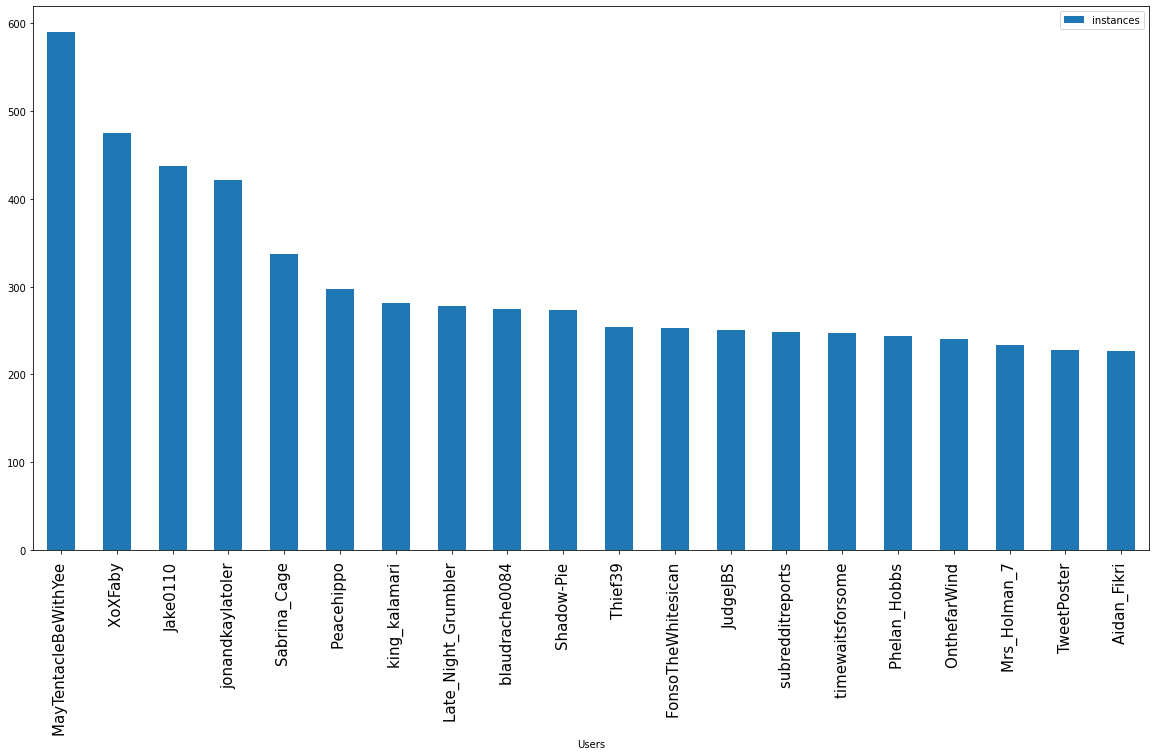

In [352]:
fig = plt.figure()
fig = topusers.plot.bar(x = 'Users',y = 'instances',figsize=(20, 10))
plt.xticks(fontsize = 15)
plt.show()

## Top Topic for each of the Top Subreddits

In [380]:
top_topics_subs = pd.read_csv('/content/reddit-comments-anaylsis/top_topics_sub/output2/part-00000', sep="\t", header=None)
top_topics_subs.columns = ['subreddit', 'topic','instances']

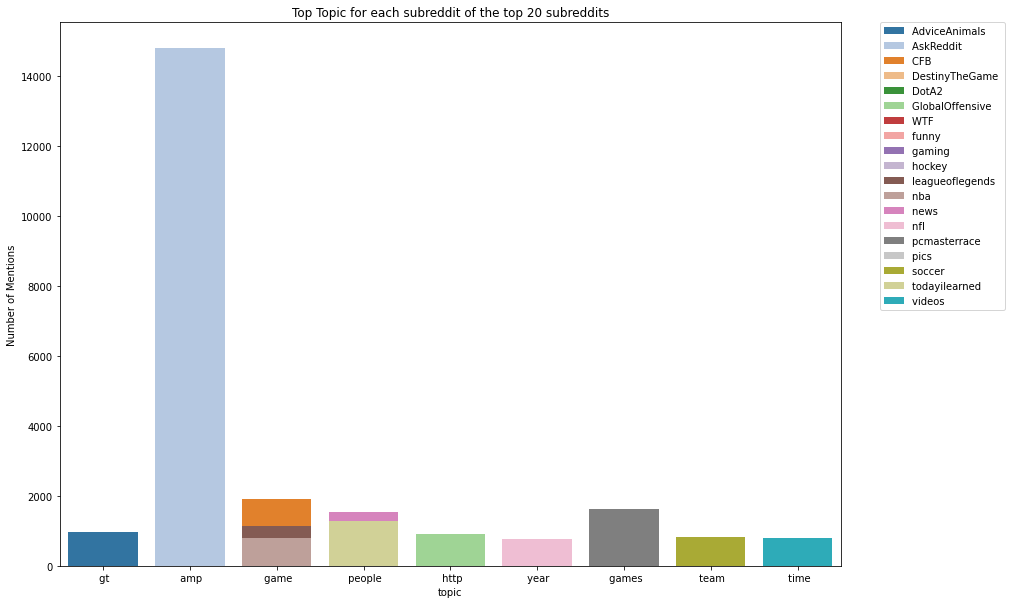

In [376]:
plt.figure(figsize=(14,10))
ax = sns.barplot(x='topic', y='instances', data=top_topics_subs, hue='subreddit', dodge=False, palette = 'tab20')
plt.title("Top Topic for each subreddit of the top 20 subreddits")
plt.ylabel("Number of Mentions")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Top Topic for each of the Top Users

In [398]:
top_topics_users = pd.read_csv('/content/reddit-comments-anaylsis/top_topics_user/output2/part-00000', sep="\t", header=None)
top_topics_users.columns = ['user', 'topic','instances']
top_topics_users = top_topics_users.drop(top_topics_users.index[[18,13]])

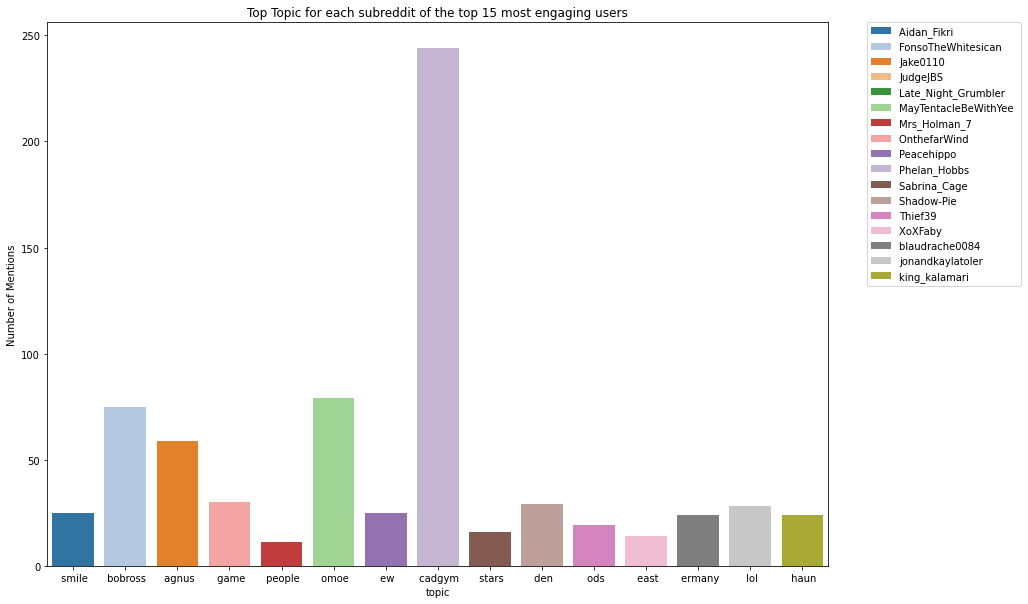

In [401]:
plt.figure(figsize=(14,10))
ax = sns.barplot(x='topic', y='instances', data=top_topics_users, hue='user', dodge=False, palette = 'tab20')
plt.title("Top Topic for each subreddit of the top 15 most engaging users")
plt.ylabel("Number of Mentions")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Top User for each of the top 20 subreddits

In [409]:
top_users_subs = pd.read_csv('/content/reddit-comments-anaylsis/top_user_per_sub/output2/part-00000', sep="\t", header=None)
top_users_subs.columns = ['subreddit', 'user','instances']

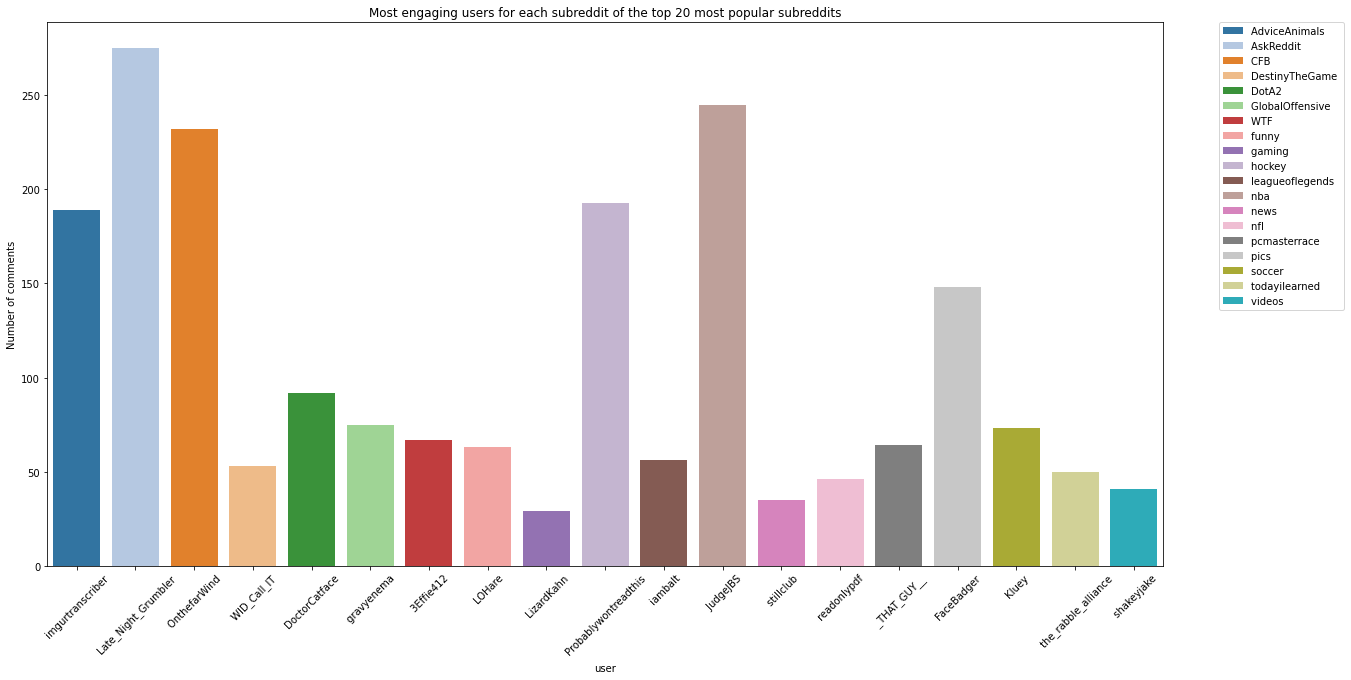

In [406]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x='user', y='instances', data=top_users_subs, hue='subreddit', dodge=False, palette = 'tab20')
plt.title("Most engaging users for each subreddit of the top 20 most popular subreddits")
plt.xticks(rotation = 45)
plt.ylabel("Number of comments")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Most Upvoted Topics

In [408]:
topics_upv = pd.read_csv('/content/reddit-comments-anaylsis/top_topics_votes/outputup/part-00000', sep="\t", header=None)
topics_upv.columns = ['Topic', 'Mentions']

In [411]:
topics_upv = topics_upv.drop(topics_upv.index[[1,19]])
topics_upv

,Topic,Mentions
0,people,511262
2,time,383848
3,gt,275805
4,year,270307
5,way,224865
6,something,202841
7,game,190381
8,years,184724
9,day,167882
10,lot,165865


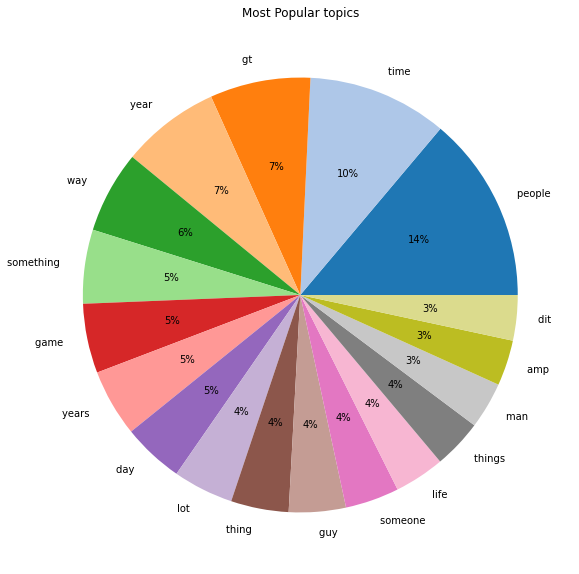

In [415]:
plt.figure(figsize=(20,10))
colors = sns.color_palette('tab20')[0:18]
plt.title("Most Popular topics")
plt.pie(topics_upv['Mentions'], labels = topics_upv['Topic'], colors = colors, autopct='%.0f%%')
plt.show()